# Pipeline example, mortality

In [12]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

from vivarium import InteractiveContext
from vivarium.framework.configuration import build_simulation_configuration
from vivarium.config_tree import ConfigTree

from vivarium_public_health.population import Mortality
from vivarium_public_health.population.spenser_population import TestPopulation
from vivarium_public_health.population.spenser_population import build_mortality_table
from vivarium_public_health.population.spenser_population import transform_mortality_table
from vivarium_public_health.population.spenser_population import prepare_dataset

## Base plugins for simulation

In [2]:
def base_plugins_simulation():
    config = {'required': {
                  'data': {
                      'controller': 'vivarium_public_health.testing.mock_artifact.MockArtifactManager',
                      'builder_interface': 'vivarium.framework.artifact.ArtifactInterface'
                  }
             }
    }

    return ConfigTree(config)

## Configure a simulation

XXX TODO: move most of the inputs to an external config file

In [3]:
def config_simulation():
    
    # read a dataset (normally from daedalus), change columns to be readable by vivarium
    # this function creates a file saved at output_path
    prepare_dataset(
        #dataset_path="../persistant_data/1000rows_ssm_E08000032_MSOA11_ppp_2011.csv", 
        dataset_path="../../daedalus/persistent_data/ssm_E08000032_MSOA11_ppp_2011.csv", 
        output_path="../persistant_data/test_ssm_E08000032_MSOA11_ppp_2011.csv",
        lookup_ethnicity="../persistant_data/ethnic_lookup.csv",
        columns_map={"Area": "location",
                     "DC1117EW_C_SEX": "sex",
                     "DC1117EW_C_AGE": "age",
                     "DC2101EW_C_ETHPUK11": "ethnicity"},
        location_code="E08000032" # if set, change all locations to this location code
    )
    
    
    # ============= CONFIGURATION
    # parent dir
    path_dir= '../persistant_data/'
    # file should have columns -> PID,location,sex,age,ethnicity
    # output file generated by prepare_dataset
    filename_pop = 'test_ssm_E08000032_MSOA11_ppp_2011.csv'
    # mortality file
    filename_mortality_rate = 'Mortality2011_LEEDS1_2.csv'

    # path to population and mortality rate files
    path_to_pop_file= f"{path_dir}/{filename_pop}"
    path_to_mortality_file= f"{path_dir}/{filename_mortality_rate}"

    pop_size = len(pd.read_csv(path_to_pop_file))
    
    # config object
    config = build_simulation_configuration()
    config.update({
        'time': {
            'start': {'year': 2011},
            'end': {'year': 2012},
            'step_size': 10
        },
        'randomness': {'key_columns': ['entrance_time', 'age']},
        'input_data': {'location': 'UK'},
    }, 
        #source=str(Path(__file__).resolve()), 
        layer='model_override')
    
    config.update({
        'path_to_pop_file': path_to_pop_file,
        'path_to_mortality_file': path_to_mortality_file,
        
        'population': {
            'population_size': pop_size,
            'age_start': 0,
            'age_end': 100,
        },
        'time': {
            'step_size': 10,
            },
        }, 
        #source=str(Path(__file__).resolve())
    )
    return config

## Create an interactive context manager

In [4]:
base_plugins = base_plugins_simulation()
config = config_simulation()
components = [TestPopulation(), Mortality()]
simulation = InteractiveContext(components=components,
                                configuration=config,
                                plugin_configuration=base_plugins,
                                setup=False)




Write the dataset at: ../persistant_data/test_ssm_E08000032_MSOA11_ppp_2011.csv


## Mortality rates

In [5]:
df = pd.read_csv(config.path_to_mortality_file)
# to save time, only look at locatiosn existing on the test dataset.
mortality_rate_df = df[(df['LAD.code']=='E08000032')]

asfr_data = transform_mortality_table(mortality_rate_df,
                                      2011,
                                      2012,
                                      config.population.age_start,
                                      config.population.age_end)

simulation._data.write("cause.all_causes.cause_specific_mortality_rate", asfr_data)

## Setup a simulation and run for `num_days`

In [6]:
simulation.setup()

2020-06-29 17:55:40.319 | DEBUG    | vivarium.framework.values:register_value_modifier:373 - Registering metrics.1.population_manager.metrics as modifier to metrics
2020-06-29 17:55:43.850 | DEBUG    | vivarium.framework.values:_register_value_producer:323 - Registering value pipeline mortality_rate
2020-06-29 17:55:43.851 | DEBUG    | vivarium.framework.values:_register_value_producer:323 - Registering value pipeline metrics


In [7]:
num_days = 365*2
simulation.run_for(duration=pd.Timedelta(days=num_days))

2020-06-29 17:56:33.477 | DEBUG    | vivarium.framework.engine:step:140 - 2011-07-02 00:00:00
2020-06-29 17:56:34.850 | DEBUG    | vivarium.framework.engine:step:140 - 2011-07-12 00:00:00
2020-06-29 17:56:36.202 | DEBUG    | vivarium.framework.engine:step:140 - 2011-07-22 00:00:00
2020-06-29 17:56:37.664 | DEBUG    | vivarium.framework.engine:step:140 - 2011-08-01 00:00:00
2020-06-29 17:56:38.940 | DEBUG    | vivarium.framework.engine:step:140 - 2011-08-11 00:00:00
2020-06-29 17:56:40.195 | DEBUG    | vivarium.framework.engine:step:140 - 2011-08-21 00:00:00
2020-06-29 17:56:41.422 | DEBUG    | vivarium.framework.engine:step:140 - 2011-08-31 00:00:00
2020-06-29 17:56:42.924 | DEBUG    | vivarium.framework.engine:step:140 - 2011-09-10 00:00:00
2020-06-29 17:56:44.221 | DEBUG    | vivarium.framework.engine:step:140 - 2011-09-20 00:00:00
2020-06-29 17:56:45.493 | DEBUG    | vivarium.framework.engine:step:140 - 2011-09-30 00:00:00
2020-06-29 17:56:46.723 | DEBUG    | vivarium.framework.engi

73

In [9]:
pop = simulation.get_population()

print (f'#alive: {len(pop[pop["alive"]=="alive"])}')
print (f'#dead: {len(pop[pop["alive"]!="alive"])}')

#alive: 513736
#dead: 8685


## Plot results

In [10]:
min_time = pop["entrance_time"].min().strftime("%Y-%m-%d")
max_time = datetime.datetime.strptime("2013-07-01", "%Y-%m-%d")

In [11]:
# --- input
# intervals for plotting (in days)
interval_in_days = 10
# list of ethnicities
sel_ethnicity = ["WBI", "WHO"]

# Population (total, for selected ethnicities, gender)
total_population = len(pop)
total_population_ETH = len(pop[pop["ethnicity"].isin(sel_ethnicity)])
total_population_male = len(pop[pop["sex"] == 1])
total_population_female = len(pop[pop["sex"] == 2])

time_axis = []
population_axis = []
population_ETH_axis = []
population_M_axis = []
population_F_axis = []

curr_time = datetime.datetime.strptime(min_time, "%Y-%m-%d")
while curr_time <= max_time:
    time_axis.append(curr_time)
    
    # dead population until current time (changes in the while loop)
    pop_dead = pop[pop["exit_time"] <= curr_time.strftime("%Y-%m-%d")]
    
    num_dead_population = total_population - len(pop_dead)
    population_axis.append(num_dead_population)
    
    num_dead_population_eth = total_population_ETH - len(pop_dead[pop_dead["ethnicity"].isin(sel_ethnicity)])
    population_ETH_axis.append(num_dead_population_eth)
    
    num_dead_male = total_population_male - len(pop_dead[pop_dead["sex"] == 1])
    population_M_axis.append(num_dead_male)
    
    num_dead_female = total_population_female - len(pop_dead[pop_dead["sex"] == 2])
    population_F_axis.append(num_dead_female)
    
    # go to next time, according to the selected interval_in_days
    curr_time = datetime.datetime.strptime(curr_time.strftime("%Y-%m-%d"), "%Y-%m-%d")
    curr_time += datetime.timedelta(days=interval_in_days)

In [14]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

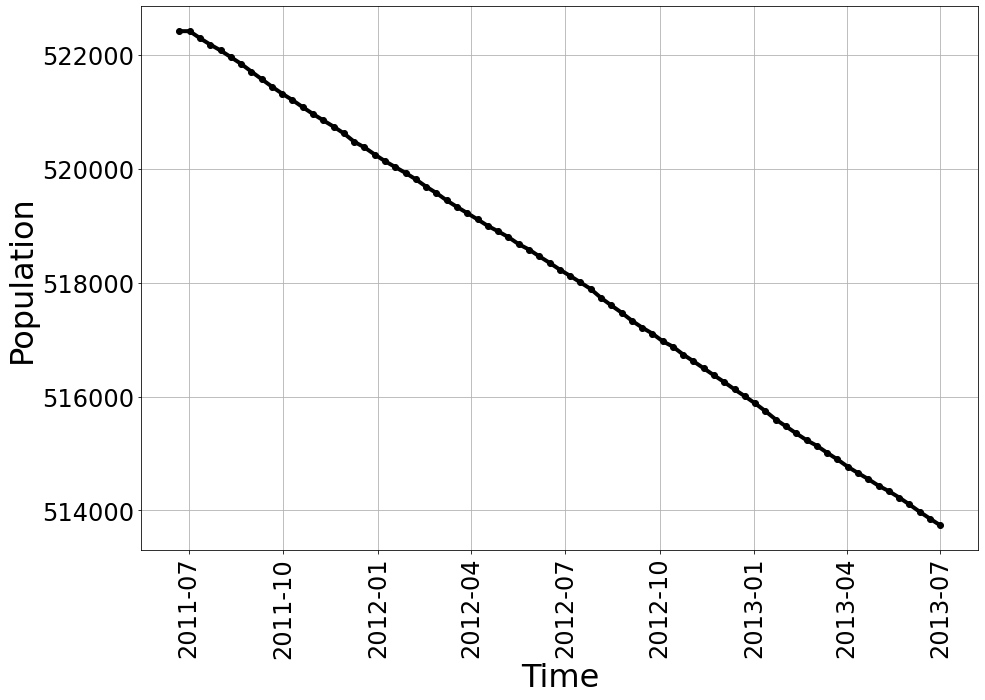

In [18]:
# Population (total)
plt.figure(figsize=(15, 10))
plt.plot(time_axis, population_axis, 
         c='k', lw=4, marker="o")
plt.xlabel("Time", size=32)
plt.ylabel("Population", size=32)
plt.xticks(size=24, rotation=90)
plt.yticks(size=24)
plt.grid()
plt.show()

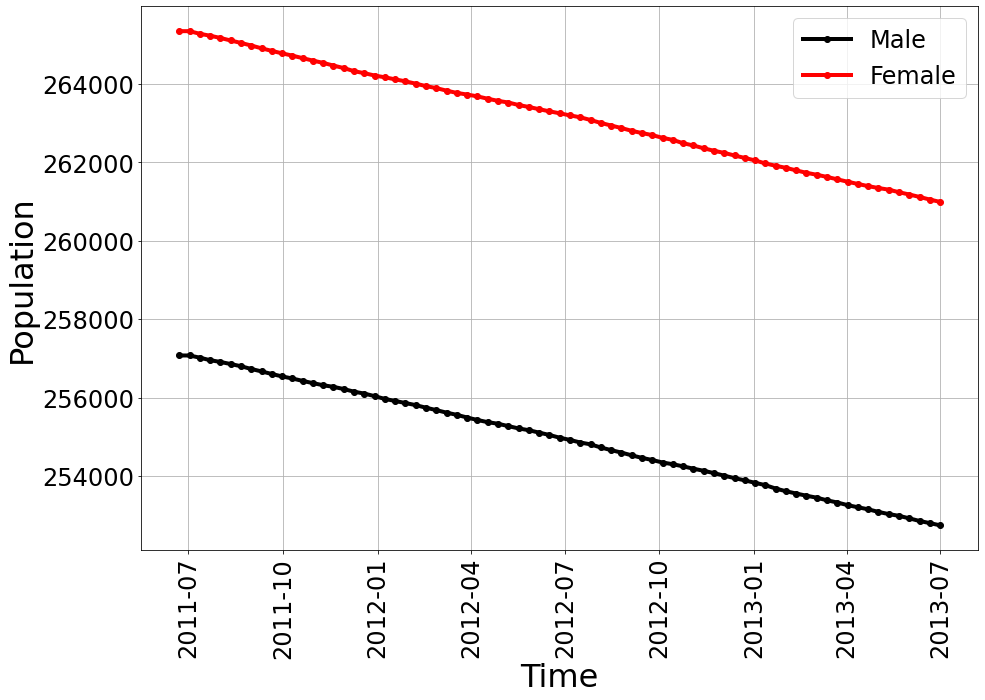

In [19]:
# Population (gender)
plt.figure(figsize=(15, 10))
plt.plot(time_axis, population_M_axis, 
         c='k', lw=4, marker="o", 
         label="Male"
        )
plt.plot(time_axis, population_F_axis, 
         c='r', lw=4, marker="o",
         label="Female"
        )
plt.xlabel("Time", size=32)
plt.ylabel("Population", size=32)
plt.xticks(size=24, rotation=90)
plt.yticks(size=24)
plt.grid()
plt.legend(fontsize=24)
plt.show()

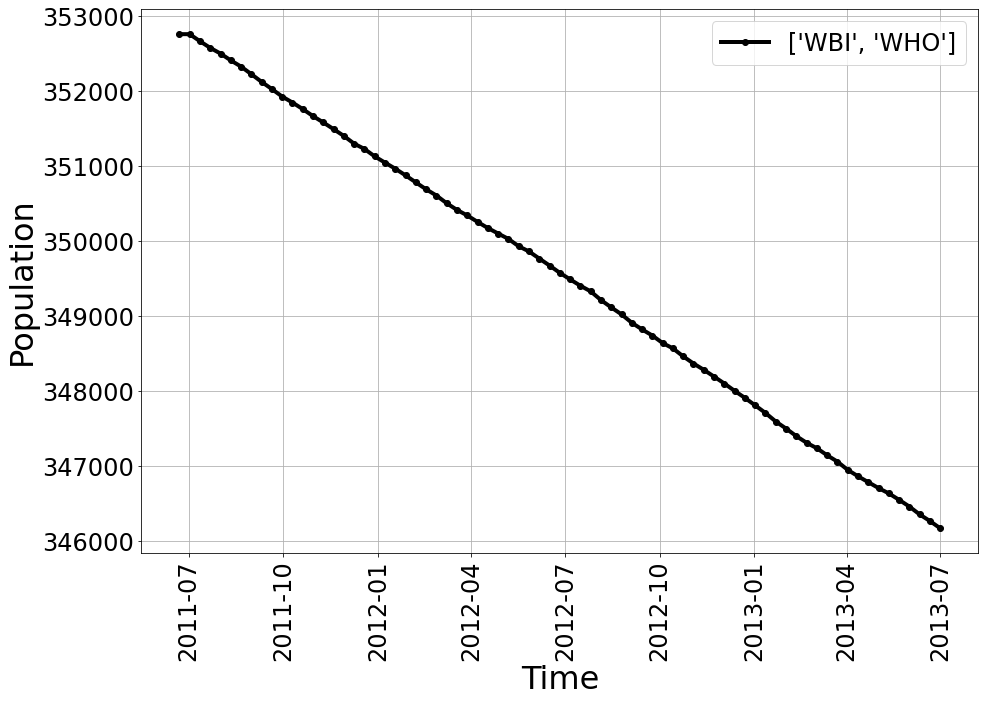

In [22]:
# Population (ethnicity)
plt.figure(figsize=(15, 10))
plt.plot(time_axis, population_ETH_axis, 
         c='k', lw=4, marker="o", 
         label=sel_ethnicity
        )
plt.xlabel("Time", size=32)
plt.ylabel("Population", size=32)
plt.xticks(size=24, rotation=90)
plt.yticks(size=24)
plt.grid()
plt.legend(fontsize=24)
plt.show()

## Histograms

In [23]:
# only dead population
pop_dead = pop[pop["alive"] != "alive"]

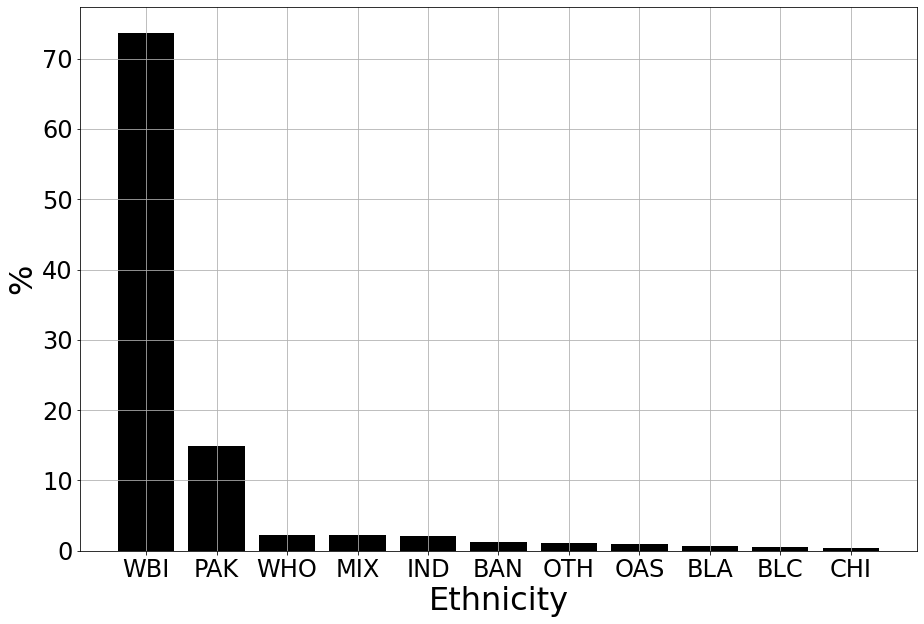

In [69]:
series2plot = pop_dead['ethnicity'].value_counts() / len(pop_dead["ethnicity"]) * 100.
indx = range(len(series2plot))

plt.figure(figsize=(15, 10))
plt.bar(indx, series2plot, color='k')

plt.xticks(indx, series2plot.index, size=24)
plt.yticks(size=24)
plt.xlabel("Ethnicity", size=32)
plt.ylabel("%", size=32)

plt.grid()
#plt.legend(fontsize=24)
plt.show()

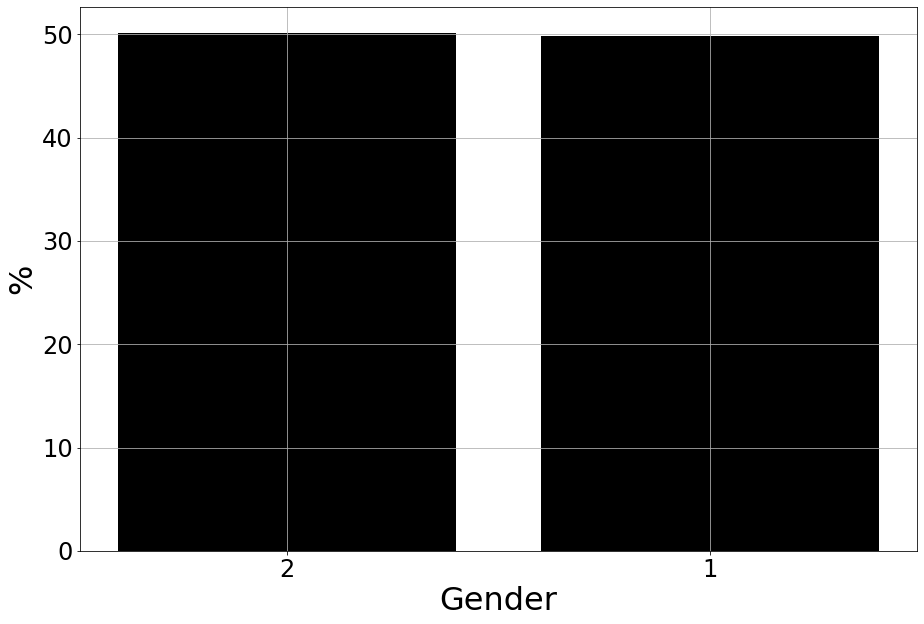

In [70]:
series2plot = pop_dead['sex'].value_counts() / len(pop_dead["sex"]) * 100.
indx = range(len(series2plot))

plt.figure(figsize=(15, 10))
plt.bar(indx, series2plot, color='k')

plt.xticks(indx, series2plot.index, size=24)
plt.yticks(size=24)
plt.xlabel("Gender", size=32)
plt.ylabel("%", size=32)

plt.grid()
#plt.legend(fontsize=24)
plt.show()

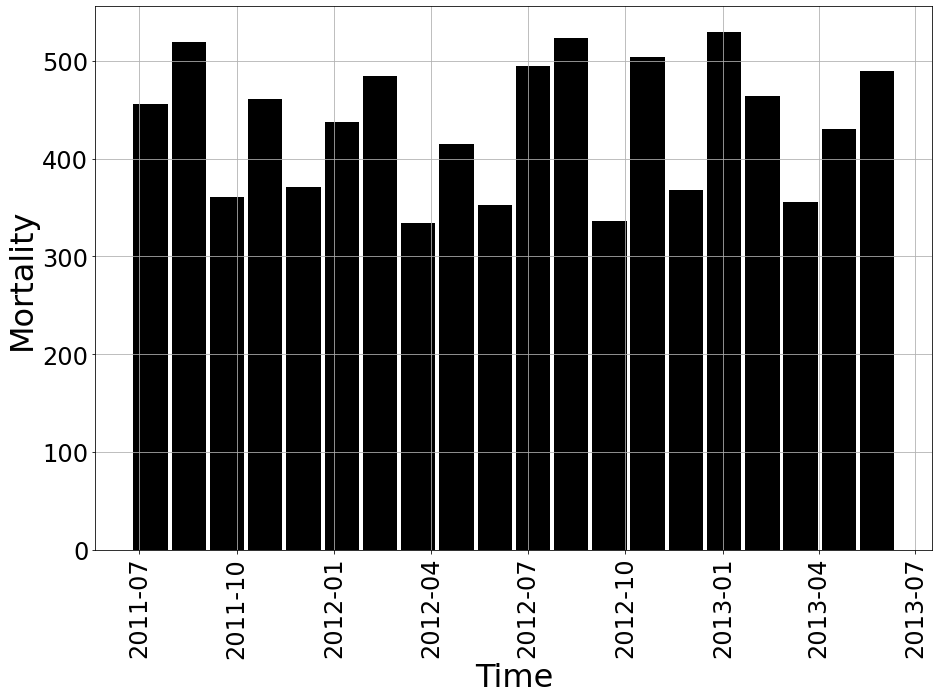

In [85]:
plt.figure(figsize=(15, 10))

pop_dead["exit_time"].hist(bins=20, 
                           rwidth=0.9, 
                           color='k',
                           align='left'
                          )
plt.xlabel("Time", size=32)
plt.ylabel("Mortality", size=32)
plt.xticks(size=24, rotation=90)
plt.yticks(size=24)
#plt.legend(fontsize=24)
plt.show()

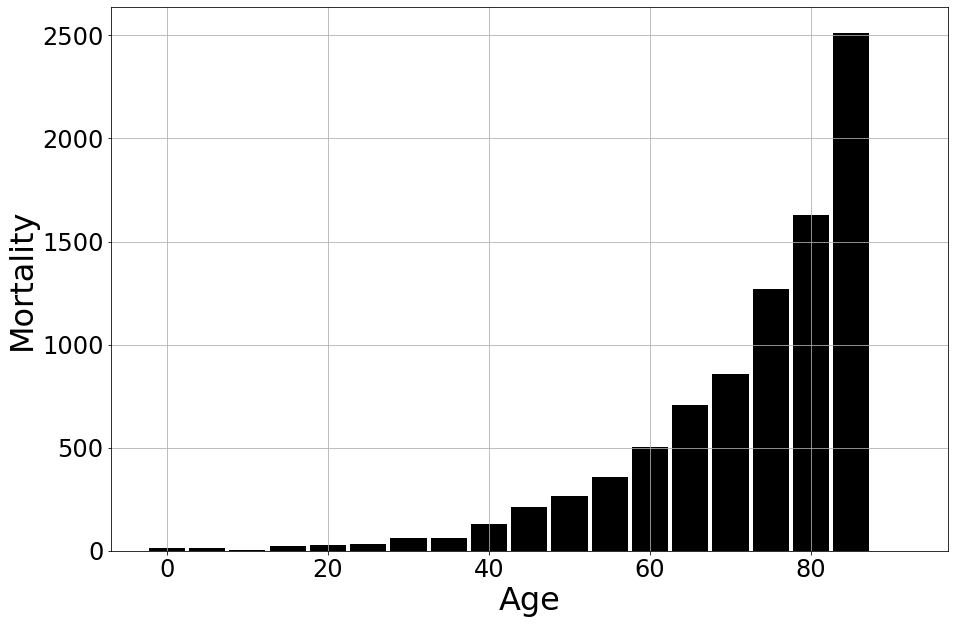

In [82]:
plt.figure(figsize=(15, 10))

pop_dead["age"].hist(bins=range(0, 100, 5), 
                     rwidth=0.9, 
                     color='k',
                     align='left'
                    )
plt.xlabel("Age", size=32)
plt.ylabel("Mortality", size=32)
plt.xticks(size=24)
plt.yticks(size=24)
#plt.legend(fontsize=24)
plt.show()

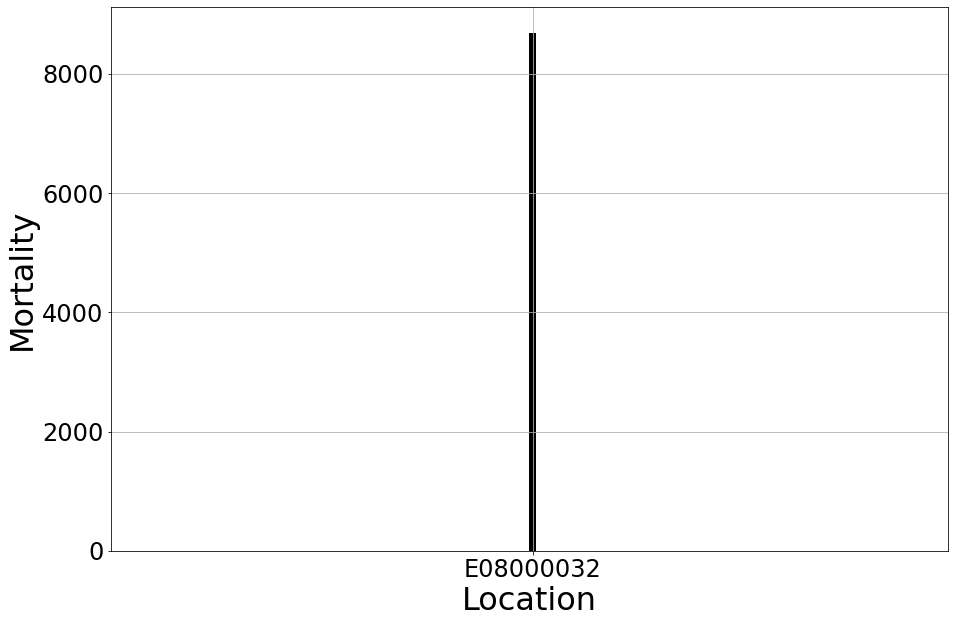

In [86]:
plt.figure(figsize=(15, 10))

pop_dead["location"].hist(bins=100, 
                          rwidth=0.9, 
                          color='k',
                          align="left"
                         )
plt.xlabel("Location", size=32)
plt.ylabel("Mortality", size=32)
plt.xticks(size=24)
plt.yticks(size=24)
#plt.legend(fontsize=24)
plt.show()